# Зависимости



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Веселье с PyLDAVis

In [2]:
! pip install numpy
! pip install pymorphy2[fast]
! pip install wikipedia
! pip install nltk
! pip install rake-nltk
! pip install transformers
! pip install -update pandas
! pip install pyLDAvis


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [3]:
import wikipedia
import random
import nltk
import re
import string
import threading
import multiprocessing
import os
import shutil
from nltk.corpus import stopwords
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import warnings 
from sklearn.linear_model import LogisticRegression
from PIL import Image
from IPython.display import clear_output


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [4]:
warnings.filterwarnings(action='ignore',category=UserWarning, module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning, module='gensim')  
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='gensim')
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='smart_open') 
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='sklearn')
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='scipy')    

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
stopWordsRu = set(stopwords.words("russian")) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
data = pd.read_csv('/content/drive/MyDrive/aiijc_sber/tokens_full_cleaned.csv')

In [47]:
data.head()

,Unnamed: 0,texts,y,tokens
0,0,Живо́тные (лат. Animalia) — традиционно (со вр...,0,живо тный лата аристотель выделять организм би...
1,1,Пти́цы (лат. Aves) — группа теплокровных яйцек...,0,пти цы лата группа теплокровный яйцекладущий п...
2,2,Союз охраны птиц России (СОПР) — общероссийска...,0,союз охрана птица россия сопра общероссийский ...
3,3,Крючковидные отростки рёбер — костяные выросты...,0,крючковидный отросток ребро костяной вырост ве...
4,4,Myxozoa (лат.) — класс или подтип паразитическ...,0,лата класс подтип паразитический беспозвоночны...


In [48]:
fixed_tokens = []
empty = 0
for  tok in data.tokens:
  aslist = tok.split()
  fixed_tokens.append(aslist)
  empty += aslist.count('')
data.tokens = fixed_tokens

In [49]:
data.head()

,Unnamed: 0,texts,y,tokens
0,0,Живо́тные (лат. Animalia) — традиционно (со вр...,0,"[живо, тный, лата, аристотель, выделять, орган..."
1,1,Пти́цы (лат. Aves) — группа теплокровных яйцек...,0,"[пти, цы, лата, группа, теплокровный, яйцеклад..."
2,2,Союз охраны птиц России (СОПР) — общероссийска...,0,"[союз, охрана, птица, россия, сопра, общеросси..."
3,3,Крючковидные отростки рёбер — костяные выросты...,0,"[крючковидный, отросток, ребро, костяной, выро..."
4,4,Myxozoa (лат.) — класс или подтип паразитическ...,0,"[лата, класс, подтип, паразитический, беспозво..."


In [50]:
data = data.drop(['Unnamed: 0'], axis=1)

In [51]:
data.head()

,texts,y,tokens
0,Живо́тные (лат. Animalia) — традиционно (со вр...,0,"[живо, тный, лата, аристотель, выделять, орган..."
1,Пти́цы (лат. Aves) — группа теплокровных яйцек...,0,"[пти, цы, лата, группа, теплокровный, яйцеклад..."
2,Союз охраны птиц России (СОПР) — общероссийска...,0,"[союз, охрана, птица, россия, сопра, общеросси..."
3,Крючковидные отростки рёбер — костяные выросты...,0,"[крючковидный, отросток, ребро, костяной, выро..."
4,Myxozoa (лат.) — класс или подтип паразитическ...,0,"[лата, класс, подтип, паразитический, беспозво..."


In [52]:
# bigram = gensim.models.Phrases(data.tokens, min_count=10, threshold=100) 
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# bigram_mod.save("/content/drive/MyDrive/aiijc_sber/bigram_model.pkl")

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

bigram_mod = gensim.models.Phrases.load("/content/drive/MyDrive/aiijc_sber/bigram_model.pkl")
processed_docs = make_bigrams(data.tokens)

In [53]:
# dictionary = Dictionary(processed_docs)
# dictionary.filter_extremes(no_below=1, no_above=0.1, keep_n= 100000)
# dictionary.save("/content/drive/MyDrive/aiijc_sber/bigram_dictionary")

dictionary = Dictionary.load("/content/drive/MyDrive/aiijc_sber/bigram_dictionary")

In [54]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [55]:
# lda_model =  LdaMulticore(tqdm(bow_corpus), 
#                           num_topics = 20, 
#                           id2word = dictionary,                                    
#                           passes = 20
#                           )

# lda_model.save("/content/drive/MyDrive/aiijc_sber/LDA_model_20_cleaned")
lda_model = LdaMulticore.load("/content/drive/MyDrive/aiijc_sber/LDA_model_20_cleaned")

In [56]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.000*"литература" + 0.000*"стать" + 0.000*"вид" + 0.000*"век" + 0.000*"история" + 0.000*"страна" + 0.000*"россия" + 0.000*"город" + 0.000*"мир" + 0.000*"война"


Topic: 1 
Words: 0.010*"музыка" + 0.006*"музыкальный" + 0.004*"стать" + 0.004*"форма" + 0.003*"ссср" + 0.003*"инструмент" + 0.003*"группа" + 0.003*"век" + 0.003*"россия" + 0.003*"слово"


Topic: 2 
Words: 0.000*"вид" + 0.000*"литература" + 0.000*"страна" + 0.000*"стать" + 0.000*"форма" + 0.000*"мир" + 0.000*"история" + 0.000*"россия" + 0.000*"группа" + 0.000*"клетка"


Topic: 3 
Words: 0.000*"стать" + 0.000*"вид" + 0.000*"страна" + 0.000*"век" + 0.000*"история" + 0.000*"клетка" + 0.000*"группа" + 0.000*"музыка" + 0.000*"россия" + 0.000*"форма"


Topic: 4 
Words: 0.000*"литература" + 0.000*"стать" + 0.000*"форма" + 0.000*"мир" + 0.000*"история" + 0.000*"музыка" + 0.000*"вид" + 0.000*"россия" + 0.000*"слово" + 0.000*"век"


Topic: 5 
Words: 0.000*"вид" + 0.000*"век" + 0.000*"история" + 0.000*"стать" + 0.000*"му

In [57]:
visualization_data = gensimvis.prepare(lda_model, bow_corpus, dictionary, mds='mmds')
pyLDAvis.display(visualization_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [58]:
features = []
volume = len(data)
counter = 0
for item in data.tokens:
    counter+=1
    lda_scores = lda_model.get_document_topics(dictionary.doc2bow(item))
    asfeatures = [0. for i in range(20)]
    for theme, score in lda_scores:
          asfeatures[theme] = score
    features.append(asfeatures)
    if counter%10000 == 0:
      print("Done", counter, "from", volume)

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(features), torch.Tensor(data.y), test_size = 0.1, shuffle=True)

In [60]:
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [61]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)

In [62]:
clf.score(X_test, Y_test)

0.7257142857142858

In [63]:
model = nn.Sequential(
    nn.Linear(20, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 4)
)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(device)

cpu


In [64]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            y_pred = model.forward(imgs)

            loss = criterion(y_pred, labels.long())
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()
        
        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                
                pred = model.forward(imgs)
                loss = criterion(pred, labels.long())
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

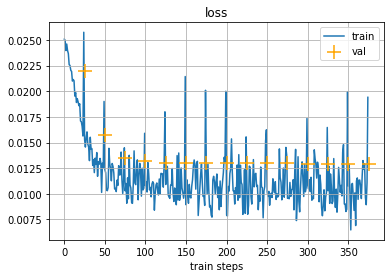

100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

Train loss: 1.0717484231979129
Val loss: 1.2912726061684745
Train acc: tensor(75.6190)
Val acc: tensor(72.)


In [65]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 train_dl, 
                                                                 test_dl)

Try 5 topics


In [ ]:
lda_model =  LdaMulticore(tqdm(bow_corpus), 
                          num_topics = 5, 
                          id2word = dictionary,                                    
                          passes = 20
                          )

lda_model.save("/content/drive/MyDrive/aiijc_sber/LDA_model_5_cleared")
# lda_model = LdaMulticore.load("/content/drive/MyDrive/aiijc_sber/LDA_model_5")

100%|██████████| 4/4 [00:00<00:00, 22.32it/s]


In [ ]:
visualization_data = gensimvis.prepare(lda_model, bow_corpus, dictionary, mds='mmds')
pyLDAvis.display(visualization_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
features = []
volume = len(data)
counter = 0
for item in data.tokens:
    counter+=1
    lda_scores = lda_model.get_document_topics(dictionary.doc2bow(item))
    asfeatures = [0. for i in range(5)]
    for theme, score in lda_scores:
          asfeatures[theme] = score
    features.append(asfeatures)
    if counter%10000 == 0:
      print("Done", counter, "from", volume)

Done 10000 from 119850
Done 20000 from 119850
Done 30000 from 119850
Done 40000 from 119850
Done 50000 from 119850
Done 60000 from 119850
Done 70000 from 119850
Done 80000 from 119850
Done 90000 from 119850
Done 100000 from 119850
Done 110000 from 119850


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(features), torch.Tensor(data.y), test_size = 0.1, shuffle=True)
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)

In [ ]:
clf.score(X_test, Y_test)

0.592991239048811

Попробуем на 16. Почему 16? Да по приколу


In [ ]:
lda_model =  LdaMulticore(tqdm(bow_corpus), 
                          num_topics = 16, 
                          id2word = dictionary,                                    
                          passes = 20
                          )

lda_model.save("/content/drive/MyDrive/aiijc_sber/LDA_model_16_cleared")

100%|██████████| 4/4 [00:00<00:00, 12.81it/s]


In [ ]:
features = []
volume = len(data)
counter = 0
for item in data.tokens:
    counter+=1
    lda_scores = lda_model.get_document_topics(dictionary.doc2bow(item))
    asfeatures = [0. for i in range(16)]
    for theme, score in lda_scores:
          asfeatures[theme] = score
    features.append(asfeatures)
    if counter%10000 == 0:
      print("Done", counter, "from", volume)

Done 10000 from 119850
Done 20000 from 119850
Done 30000 from 119850
Done 40000 from 119850
Done 50000 from 119850
Done 60000 from 119850
Done 70000 from 119850
Done 80000 from 119850
Done 90000 from 119850
Done 100000 from 119850
Done 110000 from 119850


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(features), torch.Tensor(data.y), test_size = 0.1, shuffle=True)
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)

In [ ]:
clf.score(X_test, Y_test)

0.7112223612849395